In [1]:
# The script is used to integrate data between monkey cortex and mouse cortex data
suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(harmony))
suppressMessages(library(scrattch.hicat))

options(future.globals.maxSize=100*1024^3) # 100G memory

reorder_matrix <- function(matrix1, by.rows = TRUE) {
  if (by.rows == TRUE) {
    conf.order <- order(apply(matrix1, 1, which.max))
    matrix1.reordered <- matrix1[conf.order, ]
  } else {
    conf.order <- order(apply(matrix1, 2, which.max))
    matrix1.reordered <- matrix1[, conf.order]
  }
}

compare_cl <- function(cl, ref.cl,
                       plot.title = NA, plot.silent = TRUE,
                       heat.colors = colorRampPalette(c("white", "grey70", "black"))(100),
                       row.cl.num = min(length(unique(cl)),
                                        length(unique(ref.cl)))) {
  library(grid)
  library(pheatmap)
  
  conf1 <- table(cl, ref.cl) # a count table with cl as row and ref.cl as column
  conf1 <- sweep(conf1, 1, rowSums(conf1), "/") # make the sum of each row = 1, the ratio of one cl related to each ref.cl
  conf2 <- reorder_matrix(conf1) # order the matrix to put high value to the diagonal
  
  # Cluster co-occurence
  cl.prop.cocl <- apply(conf1, 2, function(x) {
    grid1 <- expand.grid(x, x) # 一个完全展开的2列data.frame
    min.prop <- apply(grid1, 1, min)
  })
  
  cl.prop.cocl.total <- apply(cl.prop.cocl, 1, sum)
  cl.prop.cocl.m <- matrix(cl.prop.cocl.total, nrow(conf1), nrow(conf1),
                           dimnames = list(rownames(conf1), rownames(conf1)))
  # cl.prop.cocl.m 记录了cl中任意两类之间的共聚类的比例,取的是最小值之和,个人觉得这个计算方法很奇怪
  ph1 <- pheatmap(conf2, cutree_rows = row.cl.num, clustering_method = "ward.D2",
                  # annotation_row = ref.cl.anno[, -grep("cluster_label", colnames(ref.cl.anno))],
                  color = heat.colors, fontsize = 6,
                  main = plot.title, silent = plot.silent)
  return(list(conf = conf2, cocl = cl.prop.cocl.m, ph = ph1))
}

save_pheatmap_pdf <- function(x, filename, width=120, height=24) {
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  pdf(filename, width=width, height=height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

options(scipen=200)



In [2]:

outdir='/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/3species_compare_240130/data/'
integrateSeurat=readRDS(paste0(outdir, "/3species_integrate_seurat_down300_0301.rds"))


In [3]:
integrateSeurat@meta.data[grep('marmoset',(integrateSeurat@meta.data$merge_anno)),]$group='marmoset'
integrateSeurat@meta.data[grep('macaque',(integrateSeurat@meta.data$merge_anno)),]$group='macaque'
integrateSeurat@meta.data[grep('mouse',(integrateSeurat@meta.data$merge_anno)),]$group='mouse'
sub_mar=subset(integrateSeurat, group=="marmoset")
sub_maca=subset(integrateSeurat, group=="macaque")
sub_mouse=subset(integrateSeurat, group=="mouse")

In [4]:
integrateSeurat$clusterNameMod=gsub('mouse_GLUT_VENO_20','mouse_GLUT_GNB4-_20',integrateSeurat$clusterNameMod)
integrateSeurat$clusterNameMod=gsub('mouse_GLUT_VENO_5','mouse_GLUT_GNB4-_5',integrateSeurat$clusterNameMod)



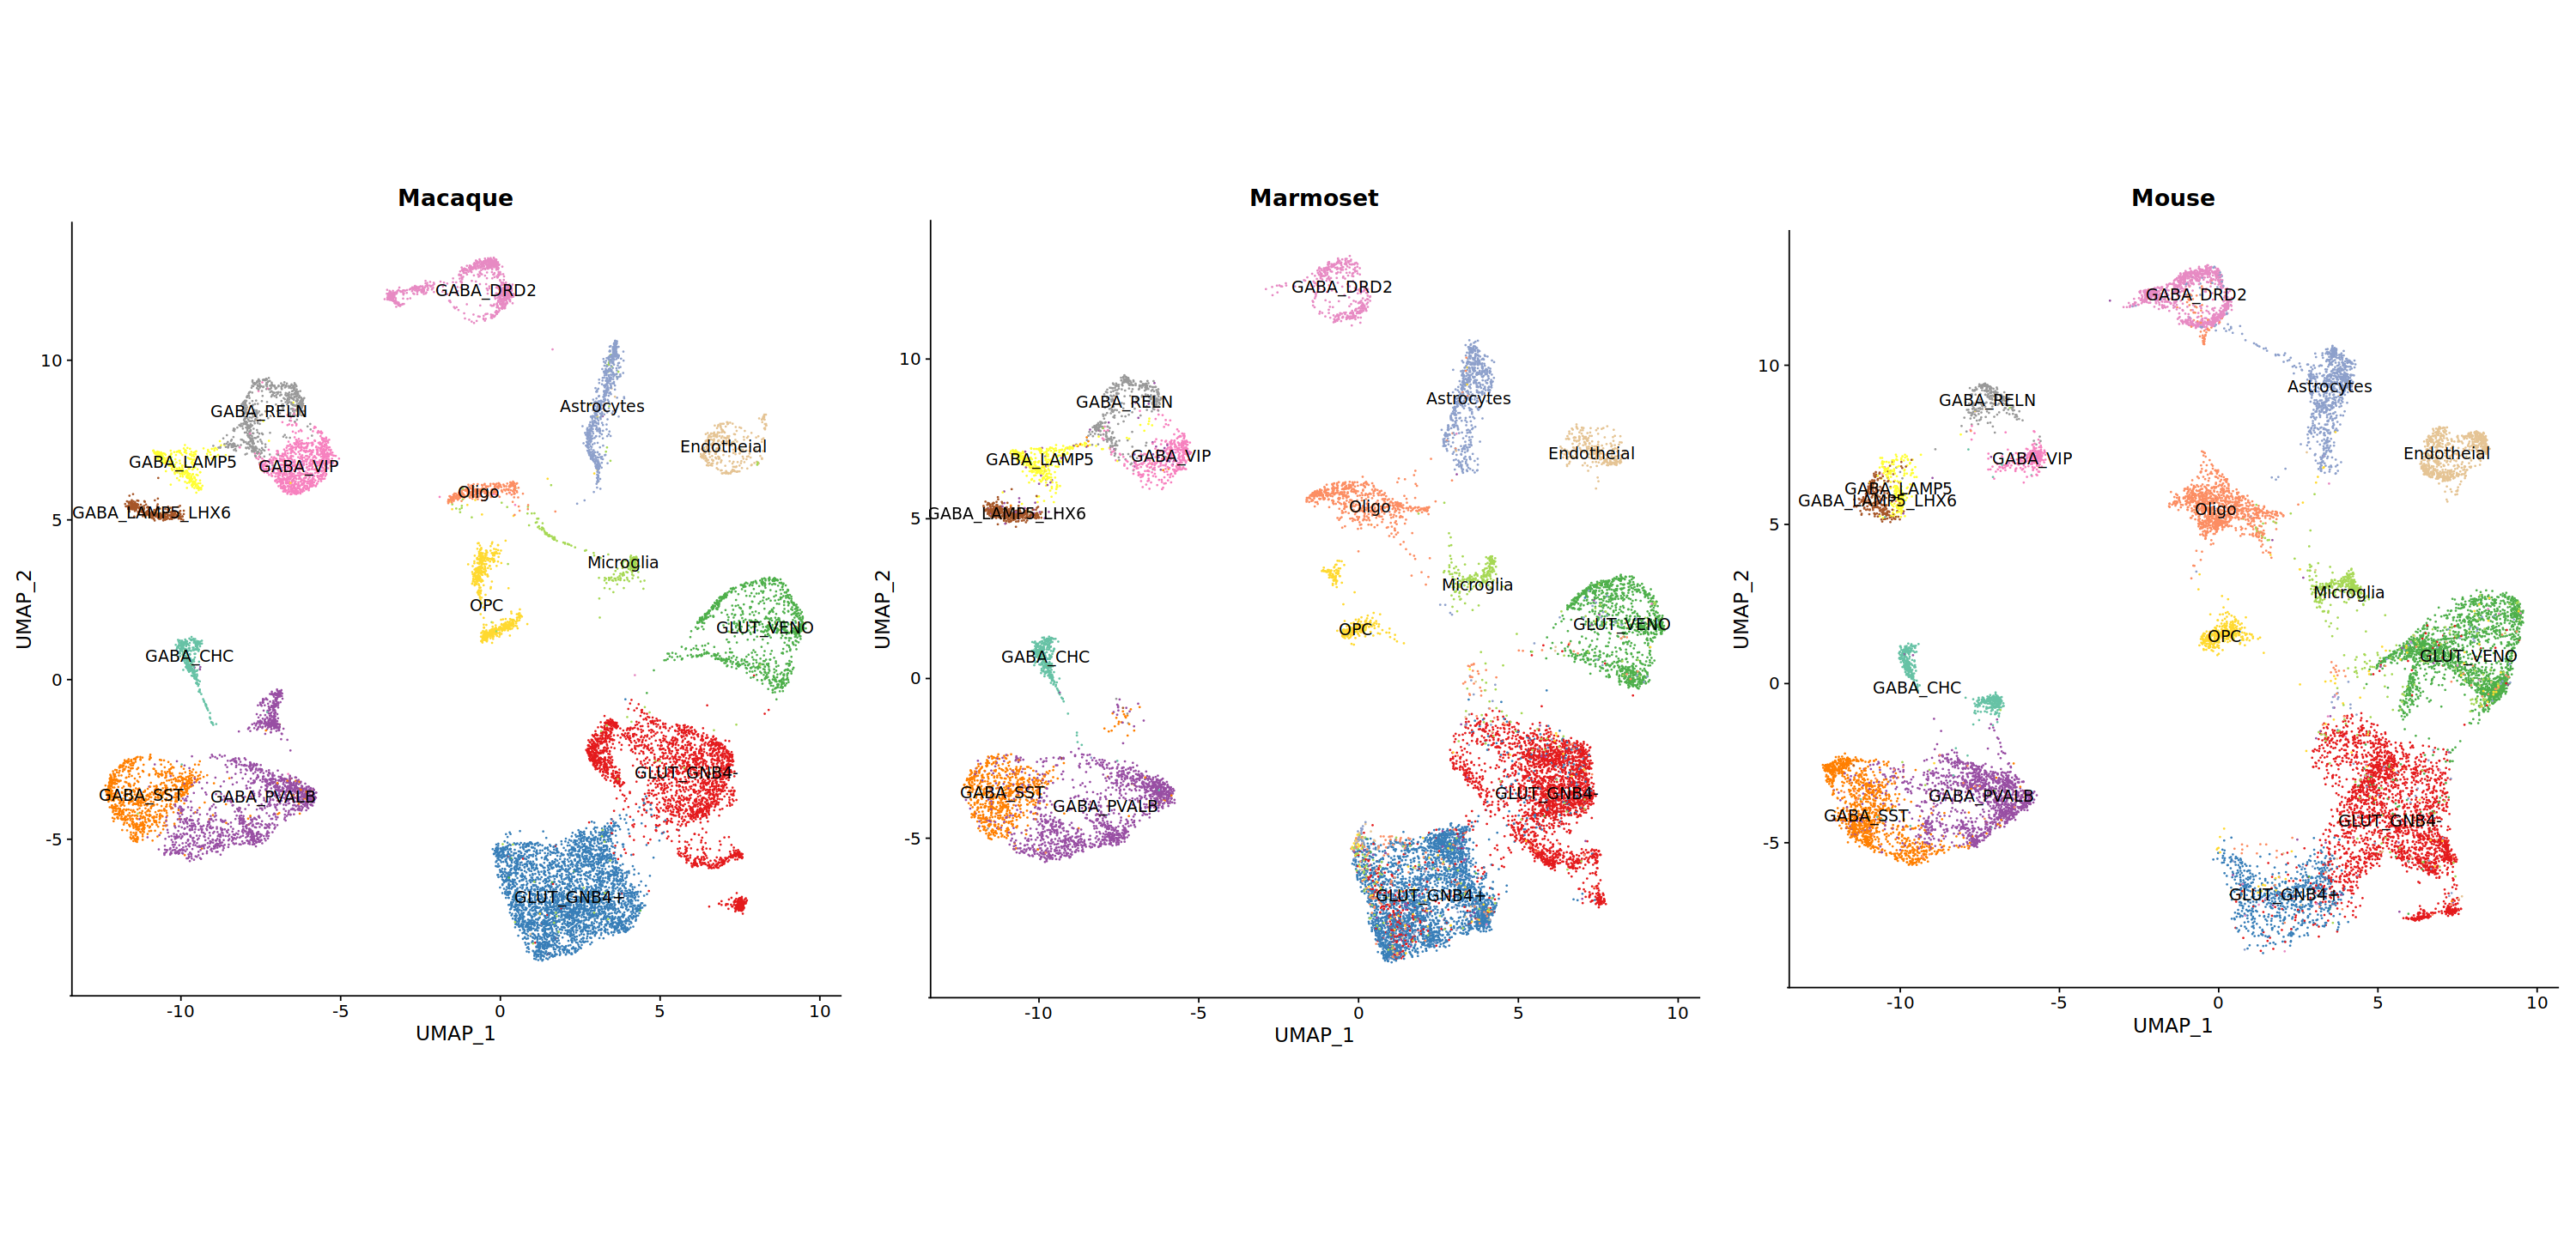

In [5]:
df_col=read.csv('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_0105/post_analysis/data/color_supercluster.csv')
#need=setdiff(unique(classFiltSeurat3$SuperCluster),df_col$X)
#for(i in c(1:length(need))){
#    df_col=rbind(df_col,c(need[i],brewer.pal(9,"Set3")[i]))
#}
col=df_col$pale
names(col)=df_col$X

options(repr.plot.width=25, repr.plot.height=12)
pg = plot_grid(
    DimPlot(sub_maca, reduction="umap", group.by="SuperCluster", label=T,raster=FALSE,cols=col)+coord_fixed()+NoLegend()+ggtitle("Macaque"),
    DimPlot(sub_mar, reduction="umap", group.by="SuperCluster", label=T,raster=FALSE,cols=col)+coord_fixed()+NoLegend()+ggtitle("Marmoset"),
    DimPlot(sub_mouse, reduction="umap", group.by="SuperCluster", label=T,raster=FALSE,cols=col)+coord_fixed()+ggtitle("Mouse")+NoLegend(),
    nrow=1, align="hv"
)
pg


In [8]:
pdf("/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/fig6_renew_240118/merge4.pdf", width=25, height=12)
pg
dev.off()


png 
  2

In [6]:
unique(integrateSeurat@meta.data$SuperCluster)

[1] "GLUT_GNB4-"      "GLUT_GNB4+"      "GLUT_VENO"       "GABA_LAMP5_LHX6"
 [5] "GABA_RELN"       "GABA_SST"        "GABA_PVALB"      "GABA_VIP"       
 [9] "GABA_LAMP5"      "GABA_CHC"        "OPC"             "Endotheial"     
[13] "Microglia"       "GABA_DRD2"       "Oligo"           "Astrocytes"

In [8]:
sub_LHX6

An object of class Seurat 
119827 features across 880 samples within 3 assays 
Active assay: integrated (2074 features, 2074 variable features)
 2 other assays present: RNA, SCT
 3 dimensional reductions calculated: pca, tsne, umap

In [10]:
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

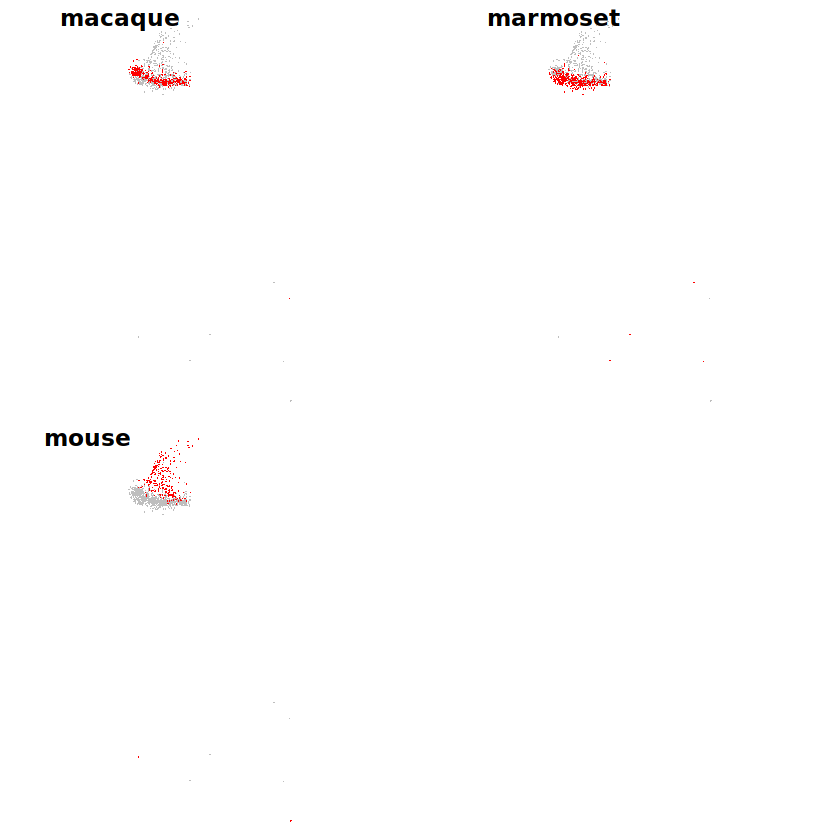

In [11]:
integrateSeurat$species=integrateSeurat$group
sub_LHX6=subset(integrateSeurat,SuperCluster=='GABA_LAMP5_LHX6')


sub_LHX6_mouse=subset(sub_LHX6,species=='mouse')
sub_LHX6_macaque=subset(sub_LHX6,species=='macaque')
sub_LHX6_marmoset=subset(sub_LHX6,species=='marmoset')


options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(sub_LHX6, highlightBy="species", showAllPoints=T, size=0.1)


In [15]:
DefaultAssay(sub_LHX6)='RNA'

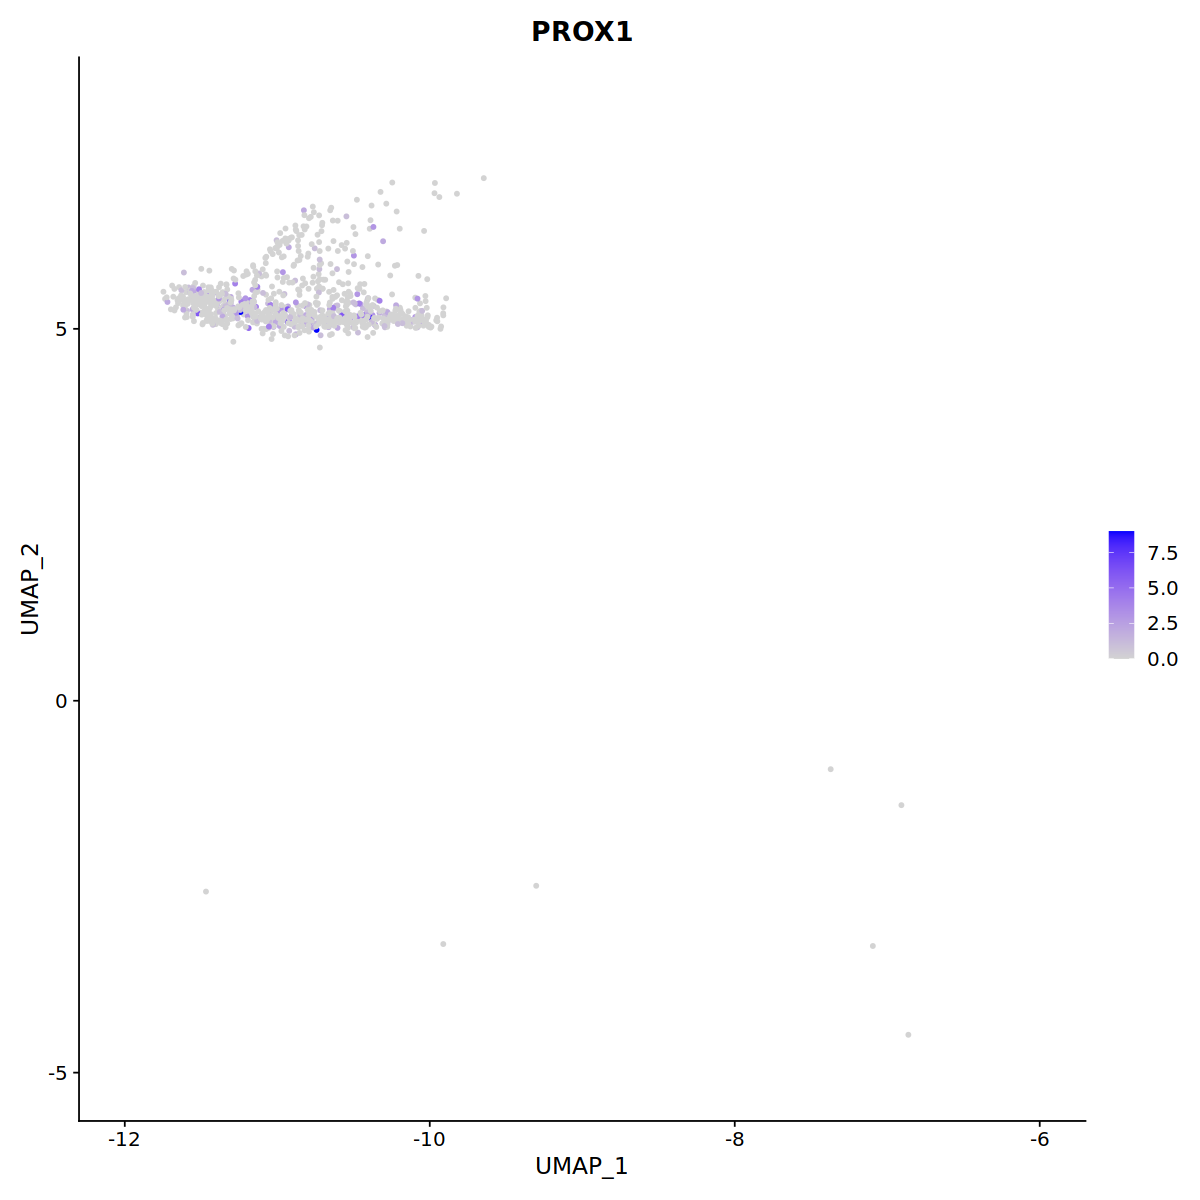

In [18]:

classMarkerTop = c('PROX1')

options(repr.plot.width=10, repr.plot.height=10)
FeaturePlot(sub_LHX6, features = classMarkerTop,raster=FALSE)


In [8]:
integrateSeurat$clusterNameMod=gsub('__','-_',integrateSeurat$clusterNameMod)



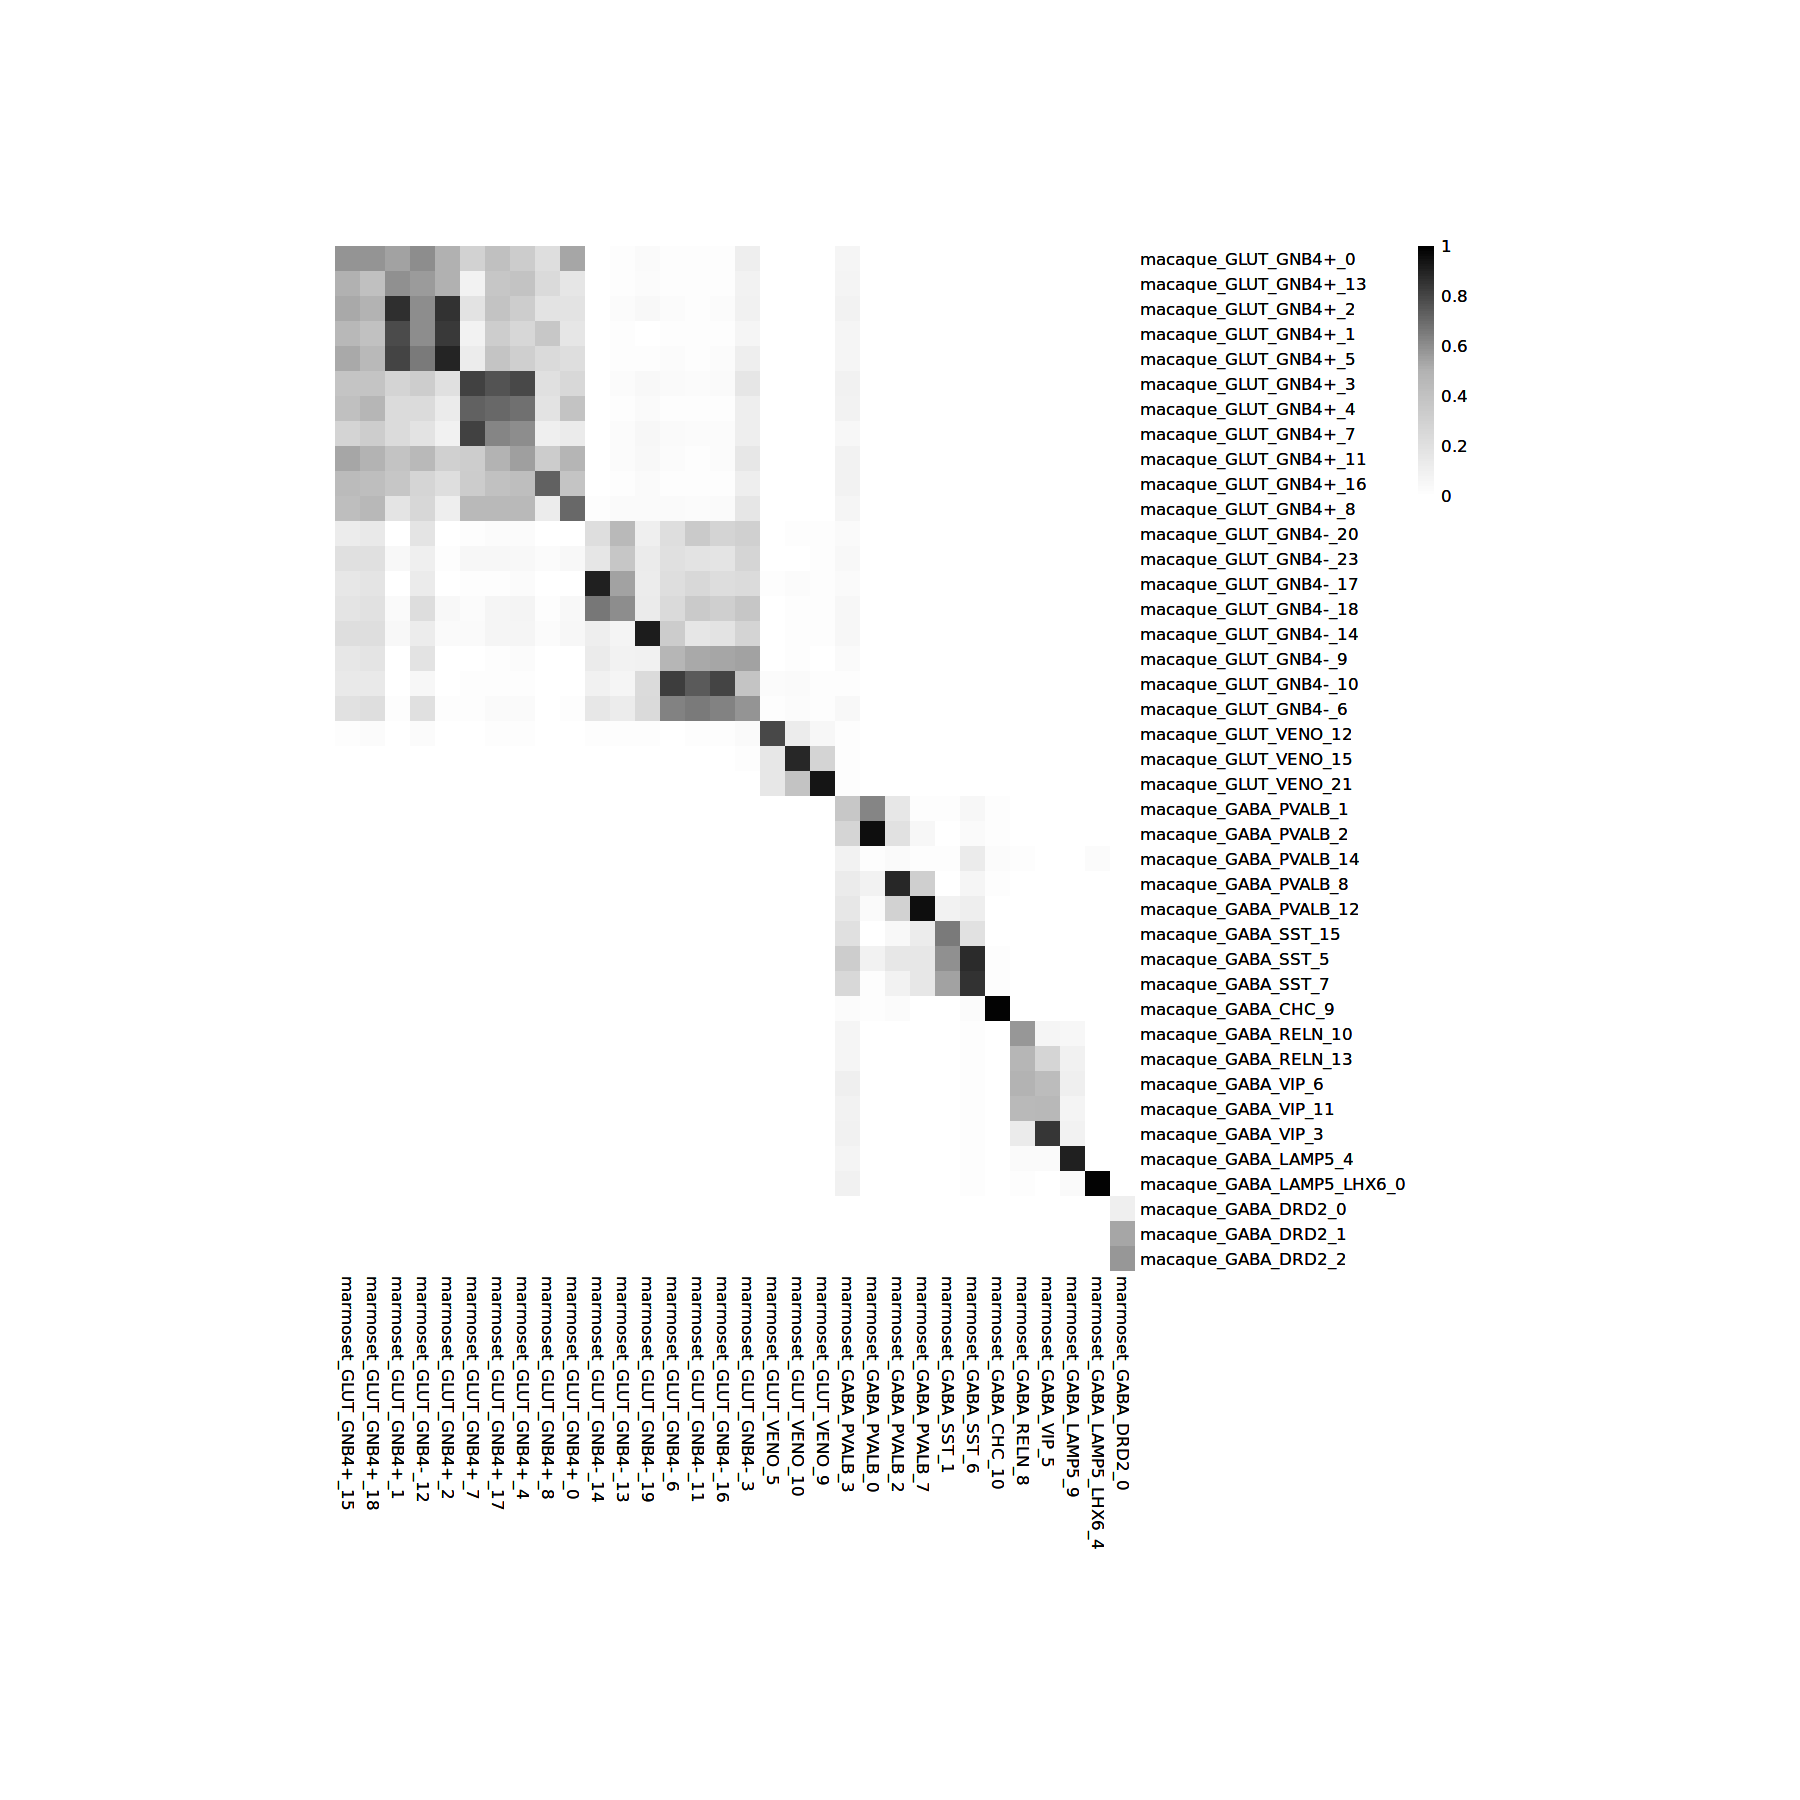

In [9]:
cl.conf <- compare_cl(integrateSeurat$clusterNameMod, integrateSeurat$seurat_clusters)
cocl <- cl.conf$cocl

cocl.subset <- cocl[grepl("macaque", row.names(cocl)),
                    grepl("marm", row.names(cocl))]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=T)
all_n=rownames(cocl.subset)
ex_n=all_n[grep('GLUT',all_n)]
in_n=all_n[grep('GABA',all_n)]
non_n1=in_n[grep('PV',in_n)]
non_n2=in_n[grep('SST',in_n)]
non_n3=in_n[grep('CHC',in_n)]
non_n4=in_n[grep('RELN',in_n)]
non_n5=in_n[grep('VIP',in_n)]
non_n6=in_n[grep('LAMP',in_n)]
non_n7=in_n[grep('DRD',in_n)]
in_n=c(non_n1,non_n2,non_n3,non_n4,non_n5,non_n6,non_n7)


cocl.subset1=cocl.subset[c(ex_n,in_n),]


cocl.subset1 = reorder_matrix(cocl.subset1, by.rows=F)

options(repr.plot.width=15, repr.plot.height=15)

heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df1=cocl.subset1


gp1=pheatmap(cocl.subset1, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp1


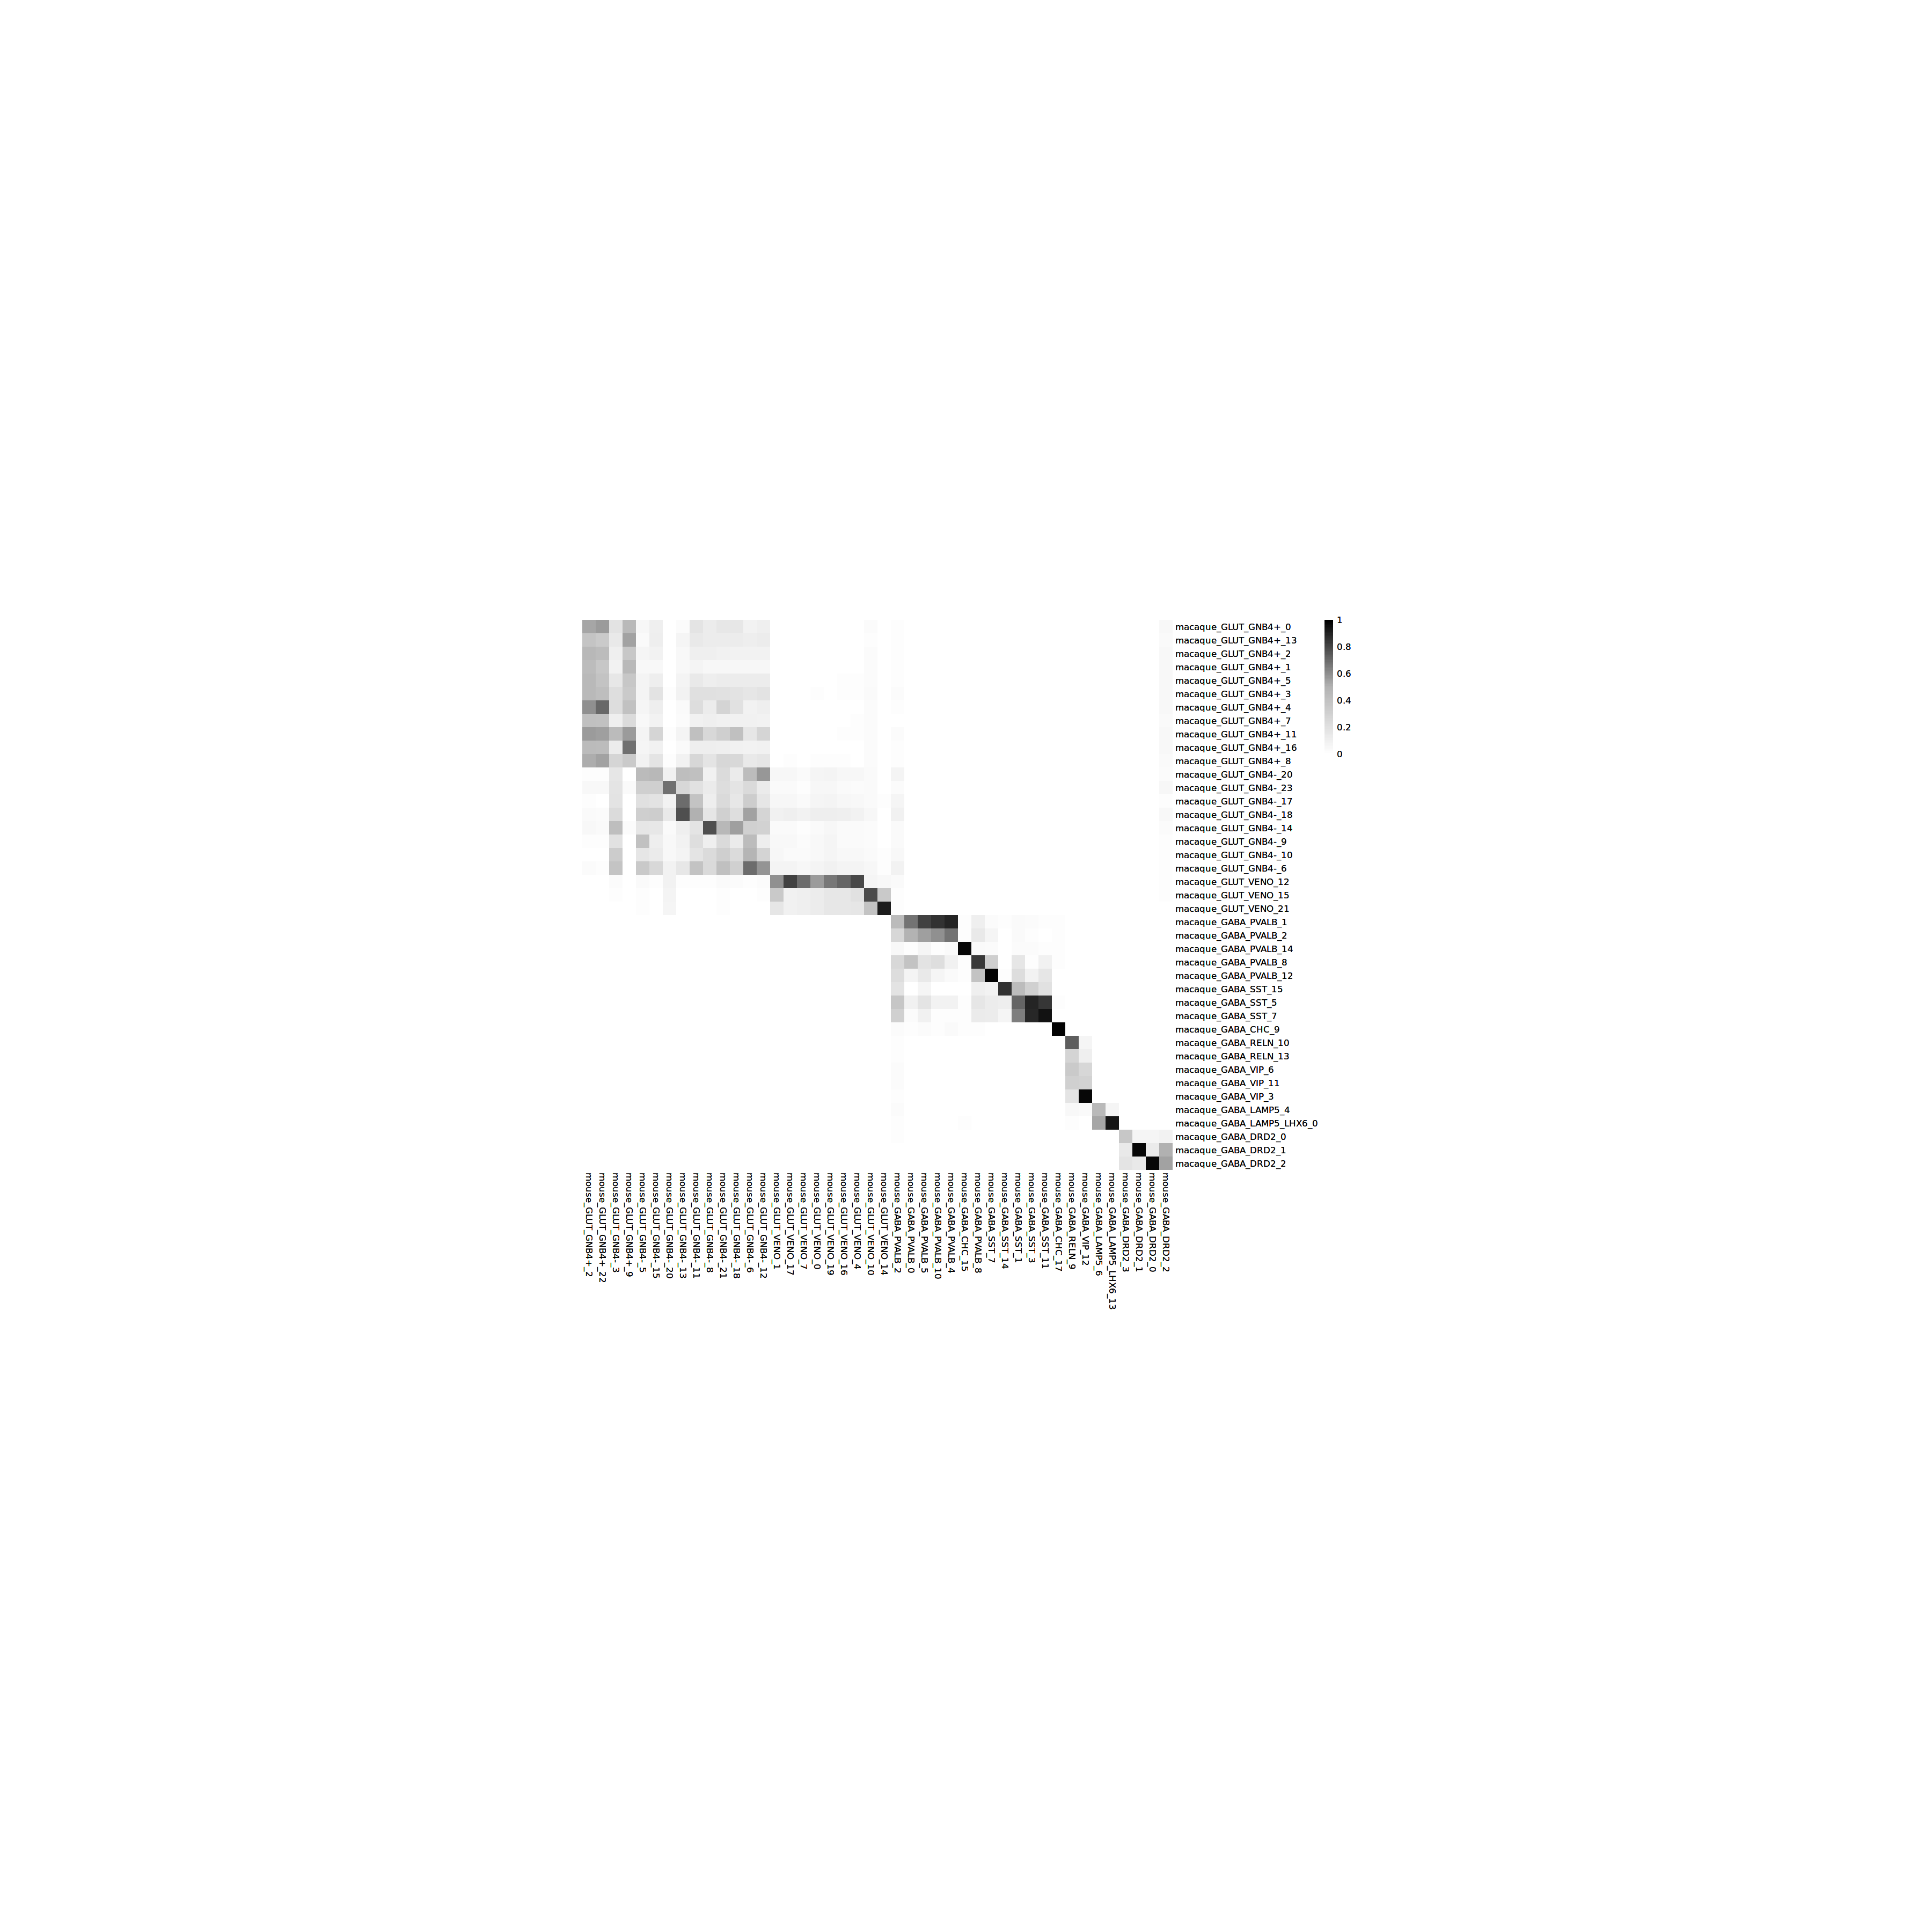

In [10]:


cocl.subset <- cocl[grepl("macaque", row.names(cocl)),
                    grepl("mouse", row.names(cocl))]
# order row by hclust
tmpDist = as.dist(1-cor(t(cocl.subset)))
tmpDist[is.na(tmpDist)]=0
ordRow = hclust(tmpDist)$order
tmpDist = as.dist(1-cor(cocl.subset))
tmpDist[is.na(tmpDist)]=0
ordCol = hclust(tmpDist)$order

cocl.subset = cocl.subset[, ordCol]
cocl.subset = reorder_matrix(cocl.subset, by.rows=T)


cocl.subset1=cocl.subset[rownames(df1),]


cocl.subset1 = reorder_matrix(cocl.subset1, by.rows=F)

options(repr.plot.width=30, repr.plot.height=30)

heat.colors <- colorRampPalette(c("white", "grey70", "black"))(100)
df2=cocl.subset


gp2=pheatmap(cocl.subset1, breaks=seq(0, 1, 0.01), cluster_rows = F, cluster_cols = F,
         #annotation_col = df_row,annotation_row = df_col,annotation_colors=ann_colors,
         color = heat.colors, border_color = NA,
         fontsize = 10, cellwidth=15, cellheight=15) 
gp2


In [11]:
save_pheatmap_pdf <- function(x, filename, width=15, height=15) {
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  pdf(filename, width=width, height=height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}



save_pheatmap_pdf(gp1,"/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/fig6_renew_240118/heat1.pdf",20,20)
save_pheatmap_pdf(gp2,"/home/liuyx/liuyuxuan/spa_seurat/cla/fig_1206/fig6_renew_240118/heat2.pdf",20,20)




png 
  2

png 
  2